
Correlation Matrix:
                                        Duration  FlowBytesSent  FlowSentRate  \
Duration                                1.000000       0.377674     -0.021003   
FlowBytesSent                           0.377674       1.000000      0.000407   
FlowSentRate                           -0.021003       0.000407      1.000000   
FlowBytesReceived                       0.108222       0.261708     -0.000779   
FlowReceivedRate                       -0.067228       0.001120      0.520033   
PacketLengthVariance                    0.011087      -0.014399     -0.005101   
PacketLengthStandardDeviation          -0.011982      -0.050453     -0.014153   
PacketLengthMean                       -0.020379      -0.021019     -0.009586   
PacketLengthMedian                     -0.009167       0.028949      0.001278   
PacketLengthMode                       -0.057785      -0.007474     -0.001263   
PacketLengthSkewFromMedian             -0.036552      -0.006283     -0.039461   
PacketL

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.10it/s]



Selected features: ['Duration', 'PacketLengthVariance', 'FlowBytesSent', 'PacketTimeSkewFromMedian', 'PacketLengthMode', 'ResponseTimeTimeMean', 'ResponseTimeTimeSkewFromMedian', 'PacketLengthCoefficientofVariation', 'ResponseTimeTimeCoefficientofVariation', 'PacketTimeMode', 'PacketLengthMean', 'PacketLengthMedian', 'PacketTimeCoefficientofVariation', 'FlowReceivedRate', 'PacketLengthStandardDeviation', 'PacketLengthSkewFromMode', 'PacketTimeSkewFromMode', 'ResponseTimeTimeStandardDeviation', 'FlowBytesReceived', 'FlowSentRate']
[LightGBM] [Info] Number of positive: 717994, number of negative: 215714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4928
[LightGBM] [Info] Number of data points in the train set: 933708, number of used features: 20
[LightGBM] [Info] [binary:BoostFromS

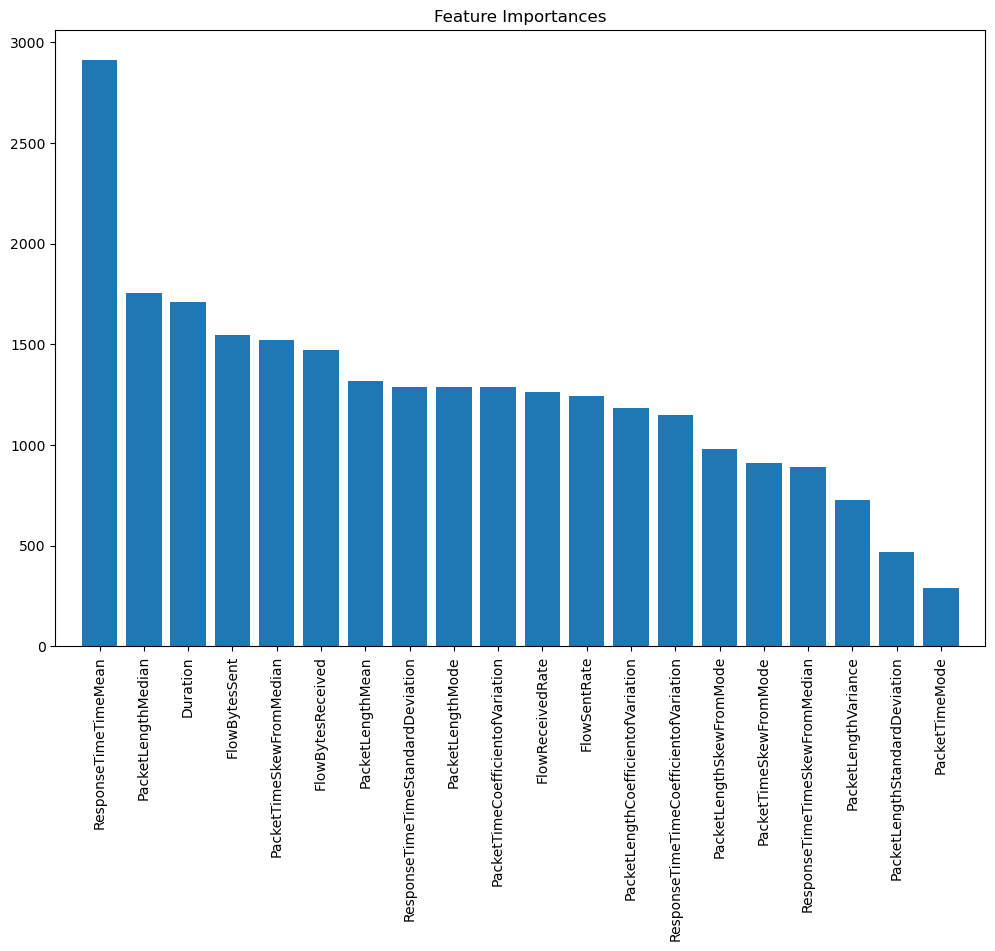

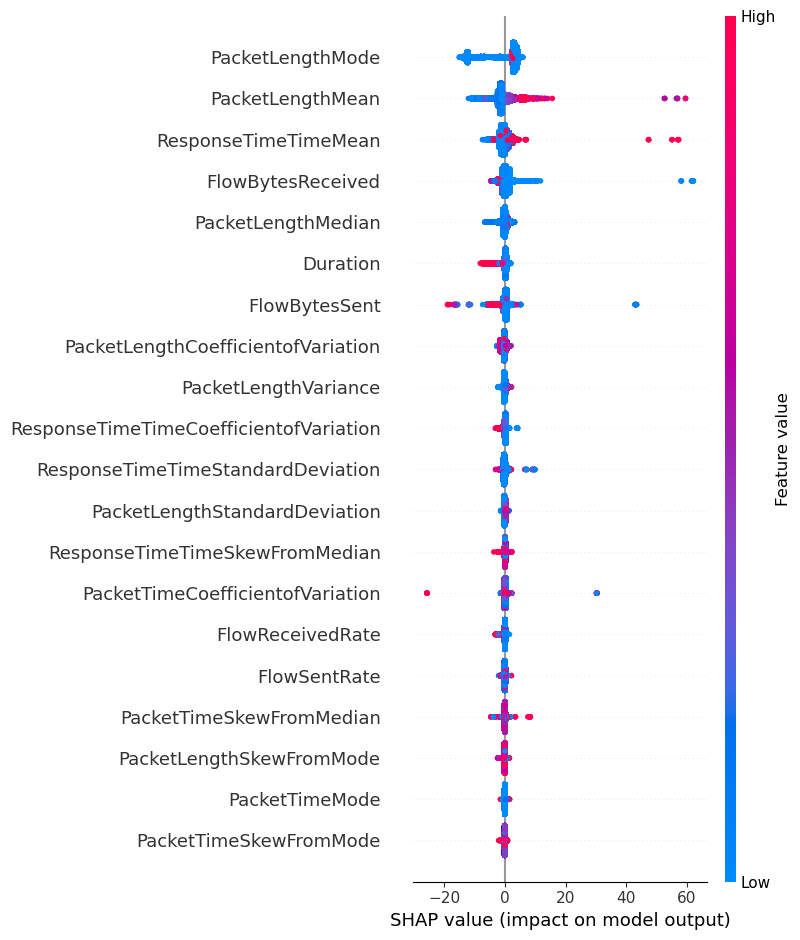

In [2]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import shap
from mrmr import mrmr_classif

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Adjust numpy types
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

# Load the datasets
doh_data = pd.read_csv('l1-doh.csv')
nondoh_data = pd.read_csv('l1-nondoh.csv')

# Add labels to the datasets
doh_data['Label'] = 'DoH'
nondoh_data['Label'] = 'NonDoH'

# Combine DoH and Non-DoH datasets
data = pd.concat([doh_data, nondoh_data], ignore_index=True)

# Drop unnecessary columns
columns_to_drop = ['SourceIP', 'SourcePort', 'DestinationIP', 'DestinationPort', 'TimeStamp']
data = data.drop(columns_to_drop, axis=1)

# Define numeric columns
numeric_columns = ['Duration', 'FlowBytesSent', 'FlowSentRate', 'FlowBytesReceived', 'FlowReceivedRate', 
                   'PacketLengthVariance', 'PacketLengthStandardDeviation', 'PacketLengthMean', 'PacketLengthMedian', 
                   'PacketLengthMode', 'PacketLengthSkewFromMedian', 'PacketLengthSkewFromMode', 
                   'PacketLengthCoefficientofVariation', 'PacketTimeVariance', 'PacketTimeStandardDeviation', 
                   'PacketTimeMean', 'PacketTimeMedian', 'PacketTimeMode', 'PacketTimeSkewFromMedian', 
                   'PacketTimeSkewFromMode', 'PacketTimeCoefficientofVariation', 'ResponseTimeTimeVariance', 
                   'ResponseTimeTimeStandardDeviation', 'ResponseTimeTimeMean', 'ResponseTimeTimeMedian', 
                   'ResponseTimeTimeSkewFromMedian', 'ResponseTimeTimeSkewFromMode', 'ResponseTimeTimeCoefficientofVariation']

# Separate features and target
X = data[numeric_columns]
y = data['Label']

# Encode categorical target variable 'Label'
le = LabelEncoder()
y = le.fit_transform(y)

# Handle missing values with mean imputation
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled data back to DataFrame to calculate correlations
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Calculate correlation matrix
correlation_matrix = X_scaled_df.corr()

# Display correlation matrix
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Identify highly correlated features (threshold > 0.9)
correlation_threshold = 0.9
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > correlation_threshold)]

# Drop highly correlated features
removed_features = []
for col in highly_correlated_features:
    corr_values = correlation_matrix.loc[correlation_matrix[col].abs() > correlation_threshold, col].to_dict()
    removed_features.append((col, corr_values))

X_scaled_df = X_scaled_df.drop(columns=highly_correlated_features)

# Check if any features are left
if X_scaled_df.shape[1] == 0:
    raise ValueError("No features left after removing highly correlated features. Adjust correlation threshold.")

print(f"\nHighly correlated features removed:")
for feature, corr_values in removed_features:
    print(f"Feature: {feature}, Correlation Values: {corr_values}")

# Apply mRMR feature selection
selected_features = mrmr_classif(X_scaled_df, y, K=20)  # Adjust K to select the desired number of features

print('\nSelected features:', selected_features)

# Reduce dataset to selected features
X_selected = X_scaled_df[selected_features]

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Cross-validation
scores = cross_val_score(LGBMClassifier(n_estimators=100, max_depth=5, min_child_samples=20, random_state=42),
                         X_selected, y, cv=5, scoring='accuracy')
print(f'\nCross-validation scores: {scores}')
print(f'Mean cross-validation score: {scores.mean()}')

# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 62, 127],
    'min_child_samples': [5, 10, 20]
}

grid_search = GridSearchCV(LGBMClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

print(f'\nBest parameters: {grid_search.best_params_}')
print(f'Best cross-validation score: {grid_search.best_score_}')

# Train LightGBM classifier with best parameters
best_lgbm = grid_search.best_estimator_
best_lgbm.fit(X_train, y_train)

# Evaluate model
y_pred = best_lgbm.predict(X_test)

# Convert predictions back to original labels
y_test_original = le.inverse_transform(y_test)
y_pred_original = le.inverse_transform(y_pred)

print('\nAccuracy:', accuracy_score(y_test_original, y_pred_original))
print('Classification Report:')
print(classification_report(y_test_original, y_pred_original))

# Print confusion matrix
print('\nConfusion Matrix:')
print(confusion_matrix(y_test_original, y_pred_original))

# Feature importance analysis
importances = best_lgbm.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X_selected.shape[1]), importances[indices], align="center")
plt.xticks(range(X_selected.shape[1]), [X_selected.columns[i] for i in indices], rotation=90)
plt.xlim([-1, X_selected.shape[1]])
plt.show()

# Model interpretation with SHAP
explainer = shap.TreeExplainer(best_lgbm)
shap_values = explainer.shap_values(X_test)

# Plot summary
shap.summary_plot(shap_values, X_test)
